# Movie Clustering
Dataset source: https://grouplens.org/datasets/movielens/

## Data Import & Cleaning
Let's get an idea of what data we have to work with from the GroupLens dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
import scipy.sparse as sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
%matplotlib notebook

movies = pd.read_csv("raw_data/movies.csv")
ratings = pd.read_csv("raw_data/ratings.csv")
tags = pd.read_csv("raw_data/tags.csv")

In [2]:
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [4]:
movies.query("movieId.isnull() or title.isnull() or genres.isnull()", engine="python")

Empty DataFrame
Columns: [movieId, title, genres]
Index: []

In [5]:
ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
ratings.query("movieId.isnull() or rating.isnull() or userId.isnull()", engine="python")

Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []

In [8]:
tags.head()

userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200

In [9]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
userId       3683 non-null int64
movieId      3683 non-null int64
tag          3683 non-null object
timestamp    3683 non-null int64
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [10]:
tags.query("userId.isnull() or movieId.isnull() or tag.isnull()", engine="python")

Empty DataFrame
Columns: [userId, movieId, tag, timestamp]
Index: []

In [11]:
tags["tag"] = tags["tag"].str.title()
tags.head()

userId  movieId              tag   timestamp
0       2    60756            Funny  1445714994
1       2    60756  Highly Quotable  1445714996
2       2    60756     Will Ferrell  1445714992
3       2    89774     Boxing Story  1445715207
4       2    89774              Mma  1445715200

### Great Data!
We don't currently have any null values!  Some movies don't have tags however, so we'll have to keep that in mind while working to clean and join our seperate dataframes

## Feature Engineering
Our datasets don't have any null values which is great!  Let's now aggregate ratings for each movie (mean, median, std.dev, etc) and then combine our movies and aggregate ratings datasets through a join on movieId.

After that, we can encode genres as binary value columns and then vectorize tags after some normalization. 

In [12]:
movie_rating_stats = ratings.loc[:,["movieId","rating"]].groupby(["movieId"]).describe()["rating"]
movie_rating_stats

count      mean       std  min   25%  50%  75%  max
movieId                                                     
1        215.0  3.920930  0.834859  0.5  3.50  4.0  4.5  5.0
2        110.0  3.431818  0.881713  0.5  3.00  3.5  4.0  5.0
3         52.0  3.259615  1.054823  0.5  3.00  3.0  4.0  5.0
4          7.0  2.357143  0.852168  1.0  1.75  3.0  3.0  3.0
5         49.0  3.071429  0.907148  0.5  3.00  3.0  3.5  5.0
...        ...       ...       ...  ...   ...  ...  ...  ...
193581     1.0  4.000000       NaN  4.0  4.00  4.0  4.0  4.0
193583     1.0  3.500000       NaN  3.5  3.50  3.5  3.5  3.5
193585     1.0  3.500000       NaN  3.5  3.50  3.5  3.5  3.5
193587     1.0  3.500000       NaN  3.5  3.50  3.5  3.5  3.5
193609     1.0  4.000000       NaN  4.0  4.00  4.0  4.0  4.0

[9724 rows x 8 columns]

### Plotting Statistics
To get a better idea of the shape of our ratings data, here are some plots.

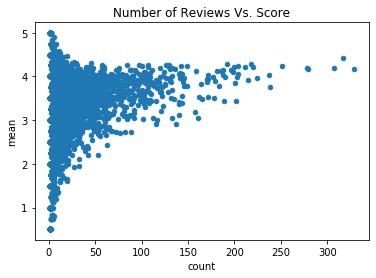

In [13]:
movie_rating_stats.plot.scatter(x="count", y="mean",title="Number of Reviews Vs. Score")

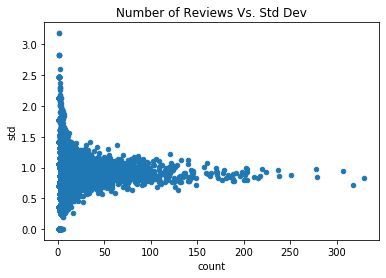

In [14]:
movie_rating_stats.plot.scatter(x="count", y="std",title="Number of Reviews Vs. Std Dev")

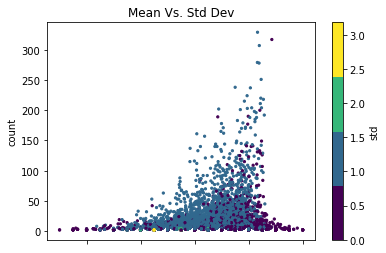

In [15]:
movie_rating_stats.plot.scatter(x="mean", y="count", c="std", s=5, cmap=cm.get_cmap("viridis",4) ,title="Mean Vs. Std Dev")

### Starting to look like a good candidate for clustering
While we haven't actually run any clustering methods on the data above, we can begin to see the data segmentation through std. dev alone.

## Clean up the tag data
Now that we have some ratings data ready to go, lets prepare our tags

In [16]:
#Groupby movieId and then concat all tags
def better_cat(arr):
    res = ""
    for s in arr:
        res = res + " " + s
    return res

agg_tags = tags.loc[:,["movieId","tag"]].groupby("movieId").agg(better_cat)
agg_tags.head()

tag
movieId                                               
1                                      Pixar Pixar Fun
2         Fantasy Magic Board Game Robin Williams Game
3                                            Moldy Old
5                                     Pregnancy Remake
7                                               Remake

In [26]:
#Since we're missing a few rows which have no tags. we'll join and then replace the nulls
movies_w_tags = movies.join(agg_tags, on="movieId").replace([None], "").join(movie_rating_stats, on="movieId")
movies_w_tags.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                             tag  count      mean       std  \
0                                Pixar Pixar Fun  215.0  3.920930  0.834859   
1   Fantasy Magic Board Game Robin Williams Game  110.0  3.431818  0.881713   
2                                      Moldy Old   52.0  3.259615  1.054823   
3                                                   7.0  2.357143  0.852168   
4                               Pregnancy Remake   49.0  3.071429  0.907148   

   min   25%  50%  75%  max  
0  0.5  3.50  4.0  4.5  5.0  
1  0.5  3.00  3.5  4.0  5.0  
2  0.5  3.00  3.0  4.0  5.0  
3  1.0  1.75  3.0  3.0  3.0  
4  0.5  3.00  3.0  3.5  5.0

In [18]:
#Lets vectorize tags for clustering
vectorizer = CountVectorizer(binary=True)
vectorized_tags = vectorizer.fit_transform(movies_w_tags["tag"])

  (0, 1186)	1
  (0, 609)	1
  (1, 548)	1
  (1, 952)	1
  (1, 187)	1
  (1, 617)	1
  (1, 1307)	1
  (1, 1714)	1
  (2, 1023)	1
  (2, 1120)	1
  (4, 1216)	1
  (4, 1279)	1
  (6, 1279)	1
  (10, 1200)	1
  (10, 1219)	1
  (13, 1200)	1
  (13, 1219)	1
  (15, 950)	1
  (16, 837)	1
  (16, 116)	1
  (20, 736)	1
  (21, 1379)	1
  (21, 879)	1
  (24, 50)	1
  (25, 1389)	1
  :	:
  (9656, 1057)	1
  (9656, 133)	1
  (9681, 610)	1
  (9681, 329)	1
  (9681, 1252)	1
  (9681, 977)	1
  (9692, 617)	1
  (9692, 37)	1
  (9692, 1660)	1
  (9692, 53)	1
  (9692, 1663)	1
  (9692, 28)	1
  (9709, 1339)	1
  (9709, 1328)	1
  (9709, 1291)	1
  (9709, 859)	1
  (9709, 214)	1
  (9710, 1464)	1
  (9710, 1682)	1
  (9710, 308)	1
  (9710, 502)	1
  (9732, 329)	1
  (9732, 80)	1
  (9732, 640)	1
  (9732, 1280)	1


In [19]:
#Add boolean encoding to genre
list_of_genres = []
movies_w_tags["year"] = 0
for i,row in movies_w_tags.iterrows():
    title_row = str(row['title'])
    one = title_row.find("(1")
    two = title_row.find("(2")
    if(one!=-1):
        year = title_row[one+1:one+5]
        movies_w_tags.at[i,"title"] = title_row[0:one-1]
    elif(two!=-1):
        year = title_row[two+1:two+5] 
        movies_w_tags.at[i,"title"] = title_row[0:two-1]
    else:
        year = 0
    movies_w_tags.at[i,"year"] = int(year)
    # Get genres
    genres = str(row['genres'])   
    if genres != '(no genres listed)':
        genres = genres.split('|')
        movies_w_tags.at[i,'genresCount'] = len(genres)
        for genre in genres:
            # New genre
            if genre not in list_of_genres:
                list_of_genres.append(genre)
                movies_w_tags[genre] = 0
            # Change the movie genre to 1
            movies_w_tags.at[i,genre] = 1
movies_w_tags.drop("genres", axis=1, inplace=True)
movies_w_tags.drop("title", axis=1, inplace=True)
movies_w_tags.drop("tag", axis=1, inplace=True)
movies_w_tags = movies_w_tags.replace([None],0)
movies_w_tags.head()

movieId  count      mean       std  min   25%  50%  75%  max  year  ...  \
0        1  215.0  3.920930  0.834859  0.5  3.50  4.0  4.5  5.0  1995  ...   
1        2  110.0  3.431818  0.881713  0.5  3.00  3.5  4.0  5.0  1995  ...   
2        3   52.0  3.259615  1.054823  0.5  3.00  3.0  4.0  5.0  1995  ...   
3        4    7.0  2.357143  0.852168  1.0  1.75  3.0  3.0  3.0  1995  ...   
4        5   49.0  3.071429  0.907148  0.5  3.00  3.0  3.5  5.0  1995  ...   

   Thriller  Horror  Mystery  Sci-Fi  War  Musical  Documentary  IMAX  \
0         0       0        0       0    0        0            0     0   
1         0       0        0       0    0        0            0     0   
2         0       0        0       0    0        0            0     0   
3         0       0        0       0    0        0            0     0   
4         0       0        0       0    0        0            0     0   

   Western  Film-Noir  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0  

[5 rows x 30 columns]

In [20]:
#Put all of the data together
all_data = sparse.hstack( [sparse.csr_matrix(movies_w_tags), vectorized_tags])
all_data.shape

(9742, 1774)

## Clustering with K-Means

First lets start by determining K through the elbow method

In [21]:
def elbowMethod(categories, max_cats): 
    its=[]
    # Assume the max number of cluster would be 10
    for i in range(1,max_cats):
        kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
        kmeans.fit(categories)
        its.append(kmeans.inertia_)

    # Find the elbow
    plt.plot(range(1,max_cats), its)
    plt.title('The Elbow Method')
    plt.xlabel('no of clusters')
    plt.ylabel('inertia')
    plt.show()
    return

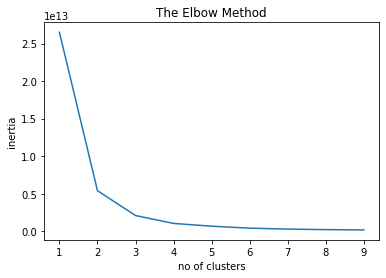

In [22]:
elbowMethod(all_data, 10)

### K-Means with k = 4
Notice the ~3 elbows at k = 2,3,4.  We'll try segmenting into 4 different categories

In [23]:
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(all_data)

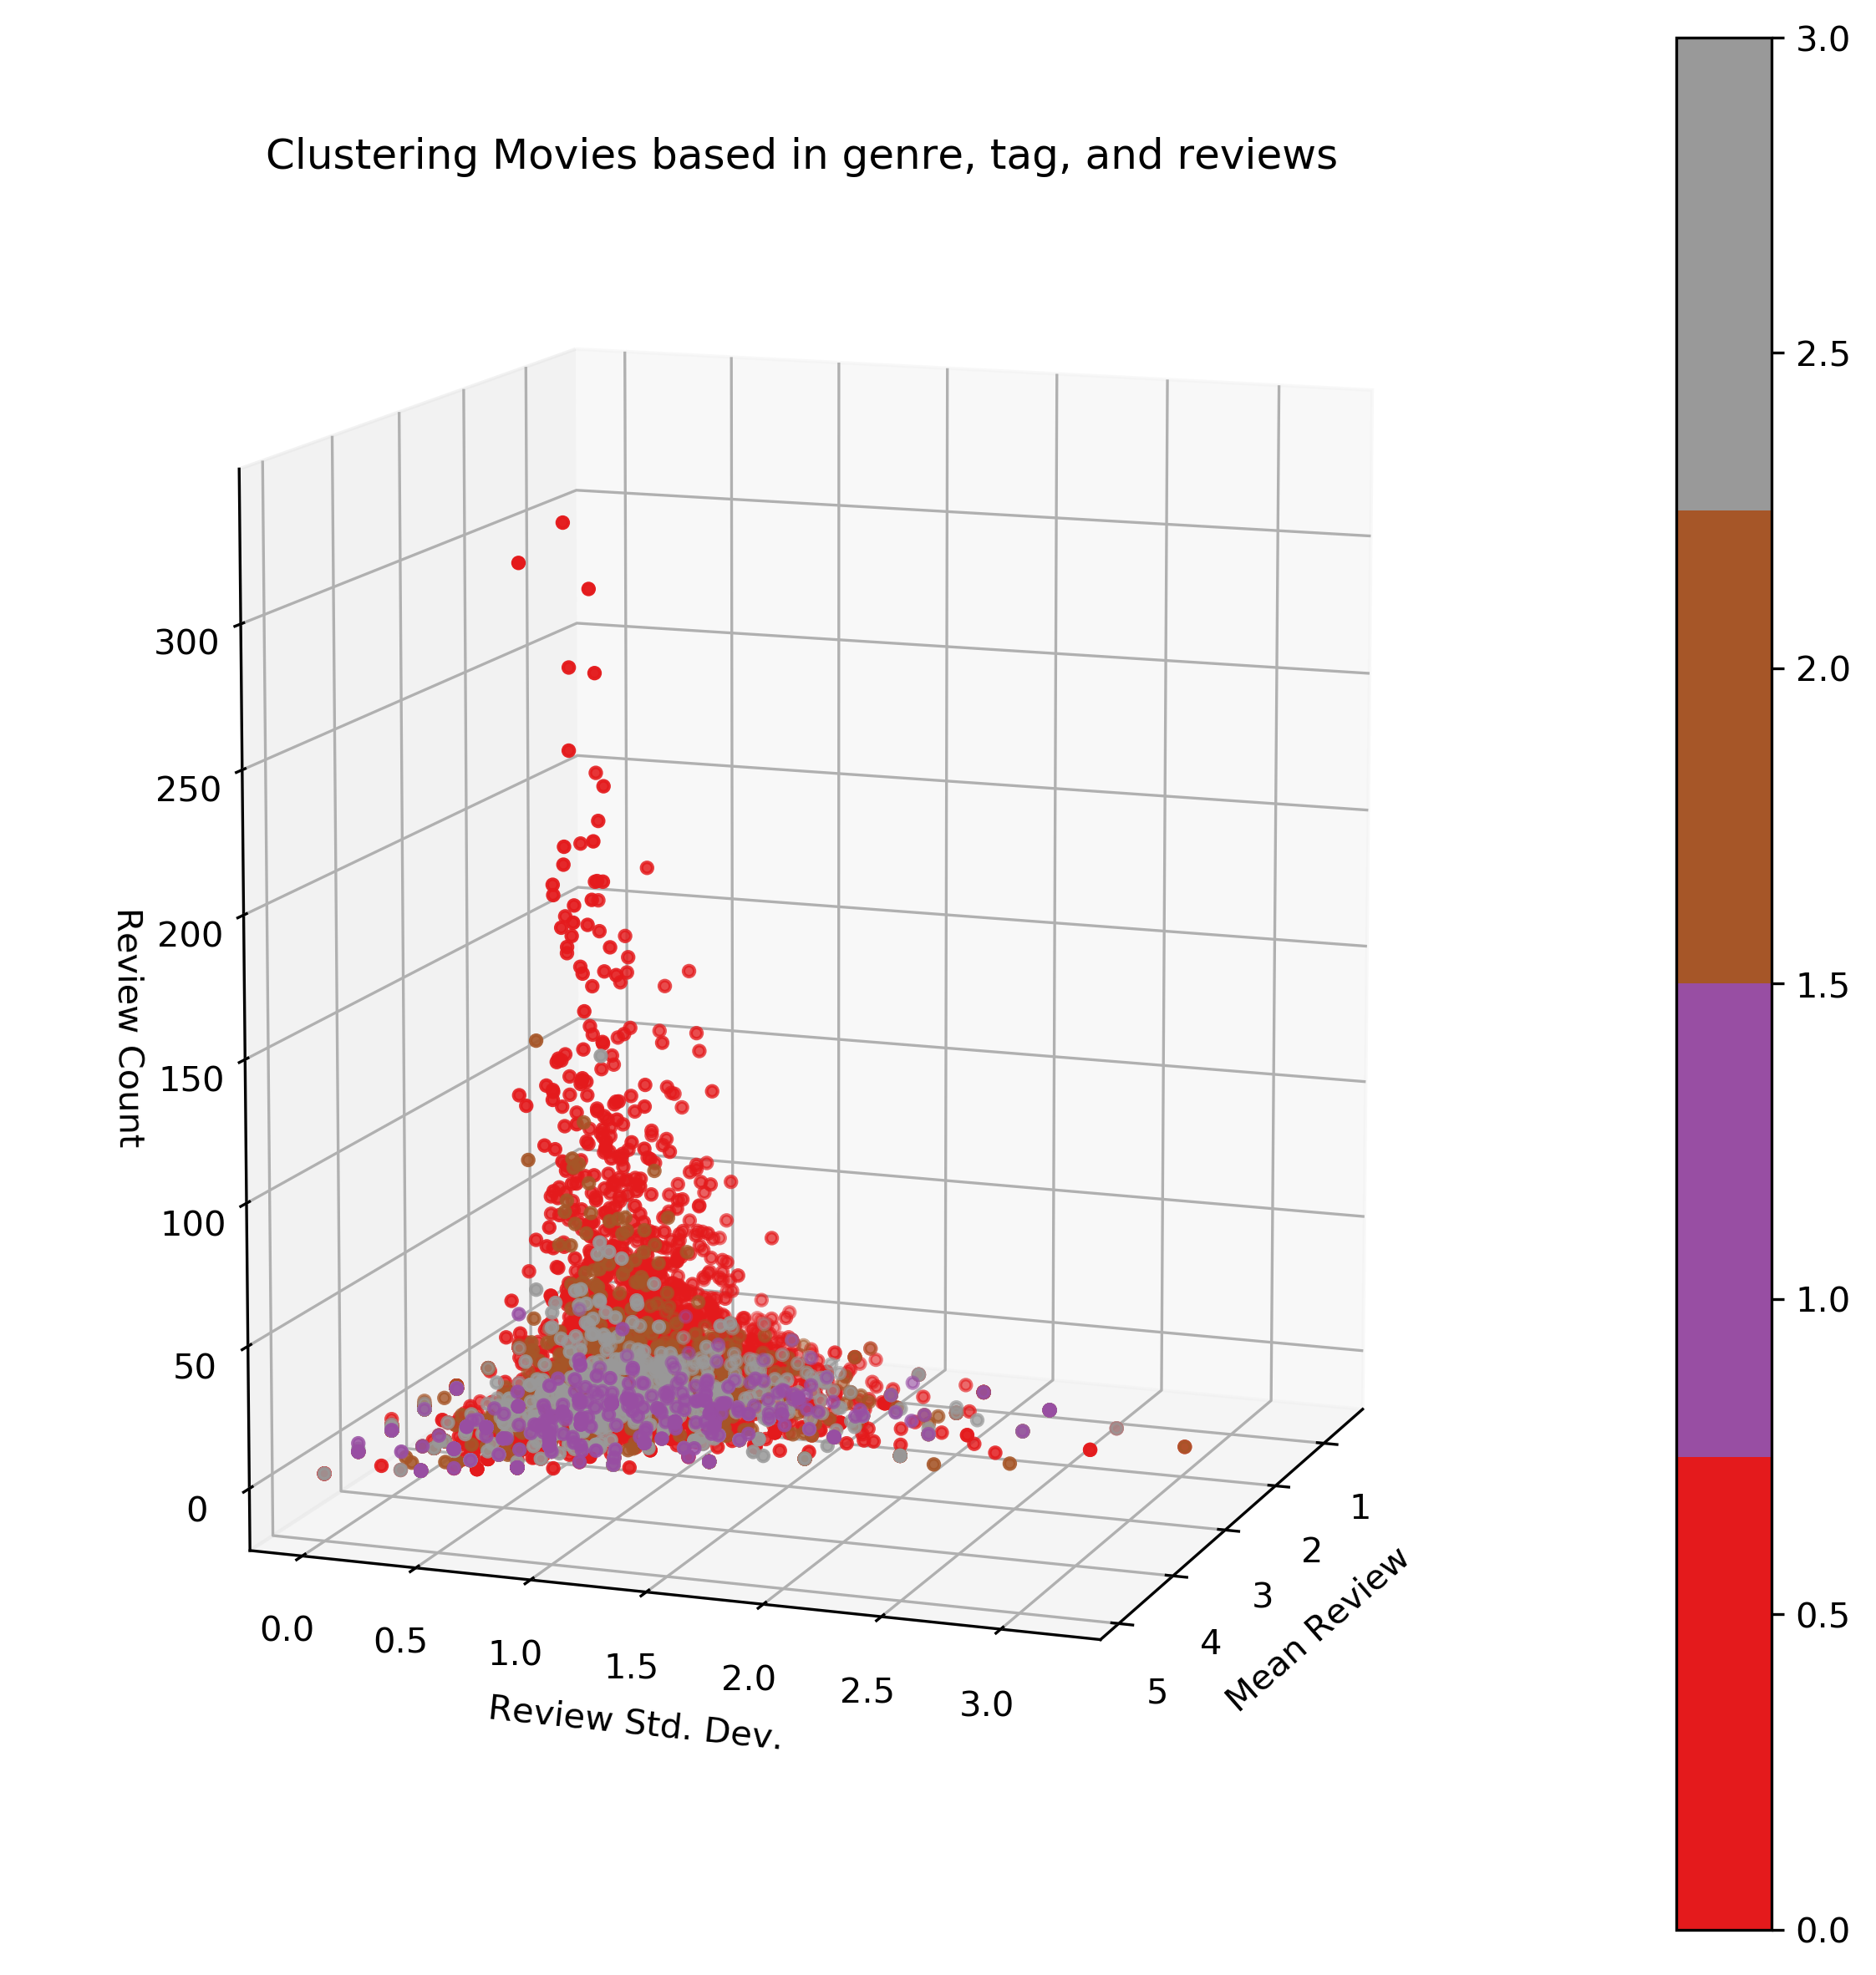

In [27]:
fig = plt.figure(figsize=(10,10), dpi = 300)
ax = plt.axes(projection='3d')
plt.colorbar(ax.scatter3D(movies_w_tags["mean"], movies_w_tags["std"], movies_w_tags["count"],
             s=10, linewidth = 1,c=labels, cmap=cm.get_cmap("Set1",4)))
ax.set_title("Clustering Movies based in genre, tag, and reviews")
ax.set_xlabel("Mean Review")
ax.set_ylabel("Review Std. Dev.")
ax.set_zlabel("Review Count")
ax.view_init(10,20)
plt.show()

# Analysis
While the above plot isn't perfect, it does display some nice divisions between the 4 categories we wanted to map movies into.  To take this a step further, lets try segmenting by the number of categories we have

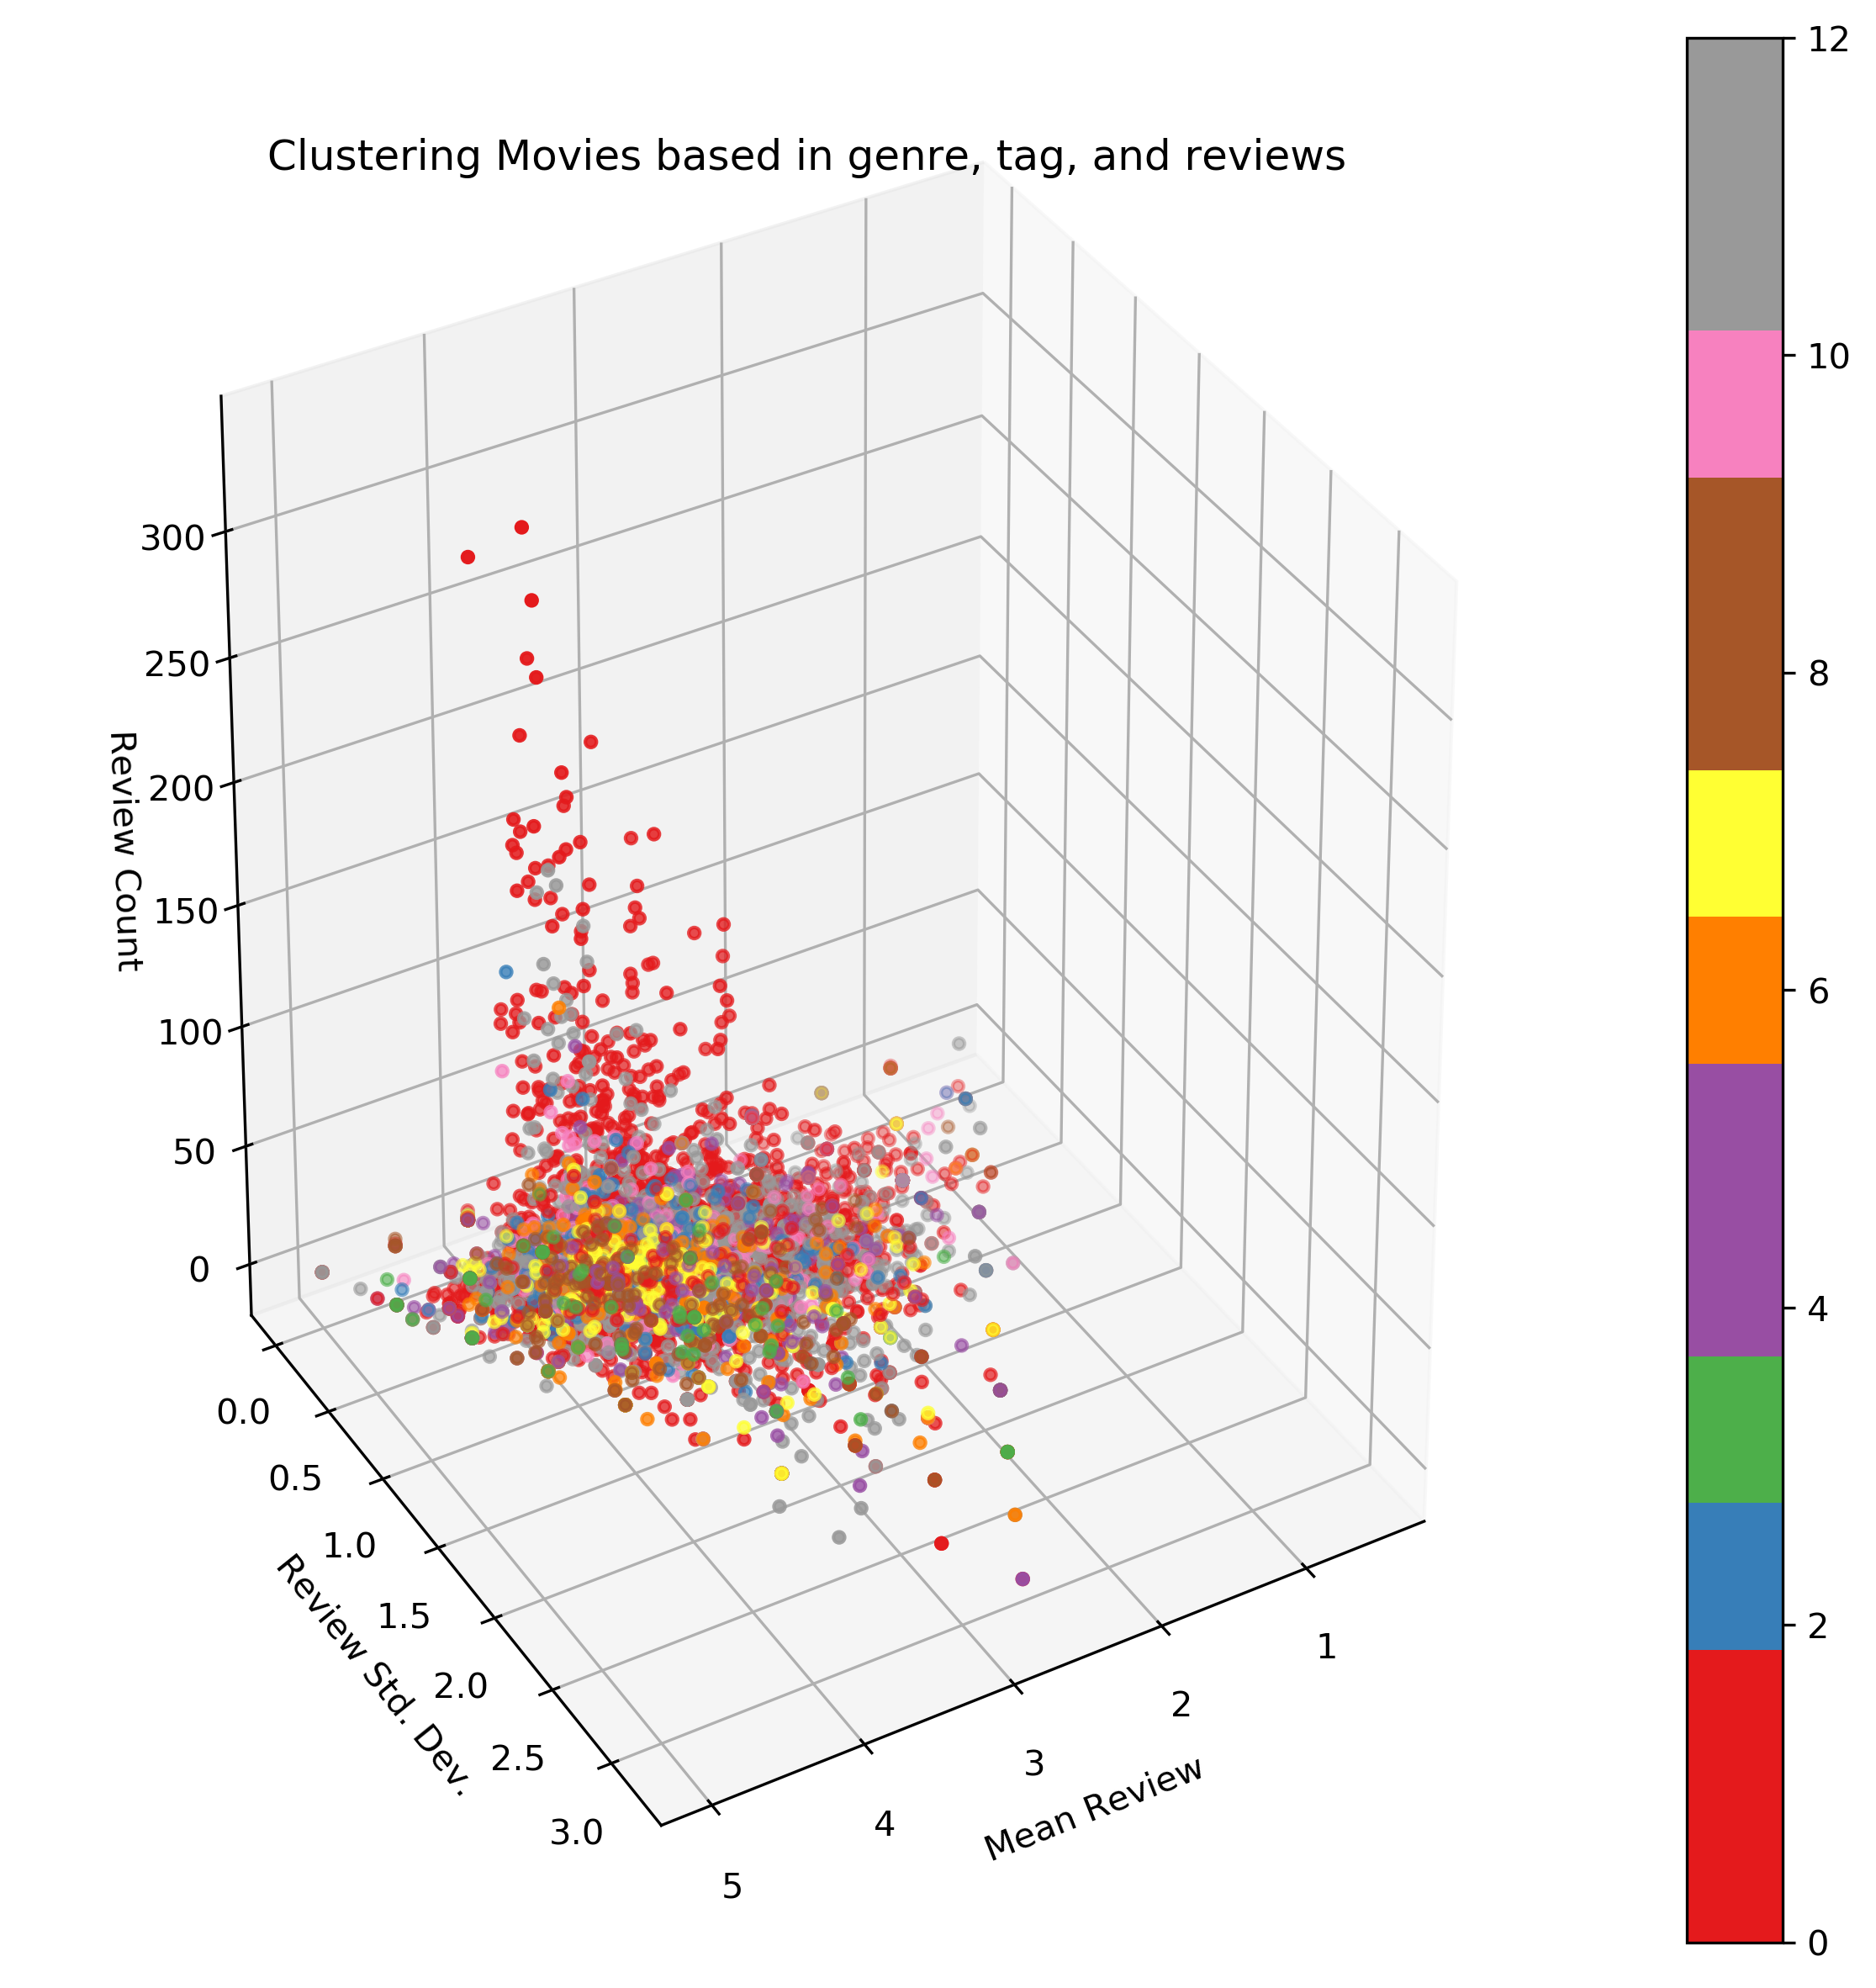

In [31]:
kmeans2 = KMeans(n_clusters=13, random_state=0)
labels2 = kmeans2.fit_predict(all_data)
fig2 = plt.figure(figsize=(10,10), dpi = 300)
ax2 = plt.axes(projection='3d')
plt.colorbar(ax2.scatter3D(movies_w_tags["mean"], movies_w_tags["std"], movies_w_tags["count"],
             s=10, linewidth = 1,c=labels2, cmap=cm.get_cmap("Set1",13)))
ax2.set_title("Clustering Movies based in genre, tag, and reviews")
ax2.set_xlabel("Mean Review")
ax2.set_ylabel("Review Std. Dev.")
ax2.set_zlabel("Review Count")
ax2.view_init(30,60)
plt.show()

# Summary
Due to the high dimensionality of our data, the k=13 plot may be harder to understand with just ratings statistics as axes.  Going forward, trying out additional idea such as clustering genres and understanding user clustering would be interesting.